iMaterialist (Fashion) 2019 is a fine-grained  segmentation task, where challengers need to develop algorithms to accurately assign segmentations and attribute labels for fashion images. [Description of the competition](https://www.kaggle.com/c/imaterialist-fashion-2019-FGVC6/overview).

This notebook is currently in development.

The first step is to implement a baseline model using U-Net. 

The EDA part of this kernel is inspired by [GoldFish](https://www.kaggle.com/go1dfish/updated4-29-fgvc6-simple-eda)

In [1]:
import numpy as np # linear algebra
import pandas as pd
pd.set_option("display.max_rows", 50)
import os
print(os.listdir("../input"))
import cv2
import json
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.size"] = 15
import seaborn as sns
from collections import Counter
from PIL import Image
import math
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import backend as k

['train', 'label_descriptions.json', 'train.csv', 'sample_submission.csv', 'test']


Using TensorFlow backend.


In [2]:
input_dir = "../input/"
train_df = pd.read_csv(input_dir + "train.csv")

Utility functions

In [3]:
def json2df(data):
    df = pd.DataFrame()
    for idx, el in enumerate(data):
        for key, val in el.items():
            df.loc[idx,key] = val
    return df

In [4]:
with open(input_dir + 'label_descriptions.json') as f:
    label_description = json.load(f)

In [5]:
print(json.dumps(label_description['info'],indent = 2))

{
  "year": 2019,
  "version": "1.0",
  "description": "The 2019 FGVC^6 iMaterialist Competition - Fashion track dataset.",
  "contributor": "iMaterialist Fashion Competition group",
  "url": "https://github.com/visipedia/imat_comp",
  "date_created": "2019-04-19 12:38:27.493919"
}


In [6]:
category_df = json2df(label_description["categories"])
attributes_df = json2df(label_description["attributes"])
category_df['id'] = category_df['id'].astype(int)
category_df['level'] = category_df['level'].astype(int)
attributes_df['id'] = attributes_df['id'].astype(int)
attributes_df['level'] = attributes_df['level'].astype(int)

In [7]:
category_df.shape[0]

46

In [8]:
attributes_df.head()

,id,name,supercategory,level
0,0,above-the-hip (length),length,1
1,1,hip (length),length,1
2,2,micro (length),length,1
3,3,mini (length),length,1
4,4,above-the-knee (length),length,1


In [9]:
category_df.id.count()

46

In [10]:
category_df.describe()

,id,level
count,46.000000,46.0
mean,22.500000,2.0
std,13.422618,0.0
min,0.000000,2.0
25%,11.250000,2.0
50%,22.500000,2.0
75%,33.750000,2.0
max,45.000000,2.0


In [11]:
#number of labels in each image
labels_count = train_df.groupby('ImageId')['ClassId'].count().value_counts().sort_index()

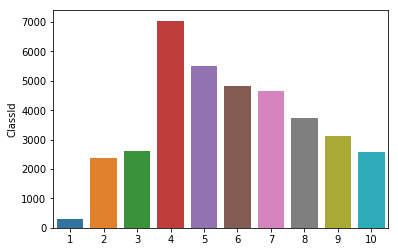

In [12]:
sns.barplot(labels_count.index[:10],labels_count[:10])

In [13]:
num_train = len(os.listdir('../input/train'))
print('The number of training image is {}'.format(num_train))
num_test = len(os.listdir('../input/test'))
print('The number of testing image is {}'.format(num_test))

The number of training image is 45625
The number of testing image is 3200


In [14]:
train_df['ClassId'].unique()

array(['6', '0', '28', ..., '10_7_20_24_60_61_88',
       '10_3_14_19_27_60_61_91', '3_6_11_19_40_60_61_88'], dtype=object)

In [15]:
WIDTH = 512
HEIGHT = 512
train_img_dir = "../input/train/"

In [16]:
category_num = category_df.shape[0] + 1 
# Q : why + 1 here??

Exploring the image segmentation

In [17]:
pallete =  [
    'Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2',
    'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c']


def make_mask_img(segment_df):
    seg_width = segment_df.at[0, "Width"]
    seg_height = segment_df.at[0, "Height"]
    seg_img = np.full(seg_width*seg_height, category_num-1, dtype=np.int32)
    for encoded_pixels, class_id in zip(segment_df["EncodedPixels"].values, segment_df["ClassId"].values):
        pixel_list = list(map(int, encoded_pixels.split(" ")))
        for i in range(0, len(pixel_list), 2):
            start_index = pixel_list[i] - 1
            index_len = pixel_list[i+1] - 1
            # assign the class label
            seg_img[start_index:start_index+index_len] = int(class_id.split("_")[0])
    seg_img = seg_img.reshape((seg_height, seg_width), order='F')
    seg_img = cv2.resize(seg_img, (WIDTH, HEIGHT), interpolation=cv2.INTER_NEAREST)

    return seg_img

def train_generator(df, batch_size):
    img_ind_num = df.groupby("ImageId")["ClassId"].count()
    index = df.index.values[0]
    trn_images = []
    seg_images = []
    for i, (img_name, ind_num) in enumerate(img_ind_num.items()):
        img = cv2.imread(train_img_dir + img_name)
        img = cv2.resize(img, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)
        segment_df = (df.loc[index:index+ind_num-1, :]).reset_index(drop=True)
        index += ind_num
        if segment_df["ImageId"].nunique() != 1:
            raise Exception("Index Range Error")
        seg_img = make_mask_img(segment_df)
        
        #         # extra one hot step
        seg_img = keras.utils.to_categorical(seg_img, num_classes=category_num, dtype=np.int32)
        
        # HWC -> CHW
#         img = img.transpose((2, 0, 1))
        #seg_img = seg_img.transpose((2, 0, 1))
        
        trn_images.append(img)
        seg_images.append(seg_img)
        if((i+1) % batch_size == 0):
            yield np.array(trn_images, dtype=np.float32) / 255, np.array(seg_images, dtype=np.int32)
            trn_images = []
            seg_images = []
    if(len(trn_images) != 0):
        yield np.array(trn_images, dtype=np.float32) / 255, np.array(seg_images, dtype=np.int32)
        
def cv2plt(img, isColor=True):
    """
    changing the representation of image from cv2 format to matplotlib format
    """
    original_img = img
    original_img = original_img.transpose(1, 2, 0) #order of channel
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB) # image colorspace
    return original_img


In [18]:
# category_num

# np.unique(segmented[0])

# print(test[1])

# plt.imshow(test[:,:,46], cmap='tab20_r', alpha=0.6)

# plt.imshow(segmented[0], cmap='tab20_r', alpha=0.6)

In [19]:
EDA = False

if EDA==True:
    original, segmented = train_generator(train_df, 6)
    fig, ax = plt.subplots(3, 2, figsize=(16, 18))
    for i, (img, seg) in enumerate(zip(original, segmented)):
        ax[i//2, i%2].imshow(cv2plt(img))
        seg[seg == 45] = 255
        ax[i//2, i%2].imshow(seg, cmap='tab20_r', alpha=0.6)
        ax[i//2, i%2].set_title("Sample {}".format(i))


To do: Image Augmentation


In [20]:
def img_gen_trn(df,batch_size):
    
    id_num_mask = df.groupby('ImageId').ClassId.count()
    batch_img,batch_mask = [],[]
    index = df.index.values[0] #initial index (not exactly zero)
    for i,(img_id,num_mask) in enumerate(id_num_mask.items()): # i,(img_id,num_mask) ?
        img = cv2.imread(train_img_dir+img_id)
        img = cv2.resize(img, (WIDTH, HEIGHT), interpolation=cv2.INTER_AREA)
        segment_df = train_df.loc[index:index+num_mask-1].reset_index(drop = True)
        index += num_mask
        if segment_df['ImageId'].nunique()!= 1:
            raise Exception("Image Index Range Error")
        seg_img = make_mask_img(segment_df)

#         # extra one hot step
        seg_img = keras.utils.to_categorical(seg_img, num_classes=category_num, dtype=np.int32)
        
        # HWC -> CHW
#         img = img.transpose((2,0,1))
#         print(img.shape)
        batch_img.append(img)
        batch_mask.append(seg_img)
        if((i+1) % batch_size == 0):
            #yield image if it reaches the batch size
            yield np.array(batch_img,dtype = np.float32)/255, np.array(batch_mask,dtype = np.int32)
            batch_img,batch_mask = [],[]
    if len(batch_img) != 0:
        yield np.array(batch_img,dtype = np.float32)/255, np.array(batch_mask,dtype = np.int32)

## Define the UNET Architecture

[UNET Website](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

[UNET Paper](https://arxiv.org/abs/1505.04597)

![unet_arch](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

The UNET consists of three path:
1. Downsampling path
2. Upsampling path
3. Skip-connection path

A Down-sampling unit consists of:
(3x3 convolution layer, ReLU)
(3x3 convolution layer, ReLU)
(2x2 max pooling layer with stride of 2)

A Up-sampling unit consists of:
(3x3 convolution layer, ReLU)
(3x3 convolution layer, ReLU)
(2x2 up convolution layer)

The up convolution layer has many other names, like decovolution layer, or the more acurate one: transposed convolution layer. In `keras` implementations, I haven't figured out whether `UpSampling2D()` layer and `Conv2DTranspose()` layer actually does the same thing, I will return to this matter latter.

By the way, I have found a very interesting repo done by [vdumoulin](https://github.com/vdumoulin/conv_arithmetic), containing some visualisations of convolution layer. if you find it hard to understand it like me, it might be useful.

In [22]:
def down_block(x,filters,kernel_size = (3,3),padding = 'same',strides = 1):
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation = "relu")(x)
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation = "relu")(c)
    p = keras.layers.MaxPool2D(pool_size = (2,2),strides = (2,2))(c)
    return c,p

def up_block(x,skip,filters,kernel_size = (3,3),padding = 'same',strides = 1):
    up = keras.layers.Conv2DTranspose(filters,kernel_size = (2,2),strides = (2,2),padding = 'same')(x)
    concat = keras.layers.Concatenate()([up,skip])
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation = "relu")(concat)
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation = "relu")(c)
    return c

def bottle_neck_block(x,filters,kernel_size = (3,3),padding = 'same',strides = 1):
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation = "relu")(x)
    c = keras.layers.Conv2D(filters,kernel_size,padding=padding,strides=strides,activation = "relu")(c)
    return c


In [23]:
def UNet(f = [64,128,256,512,1024]):
    
    #input layer
    inputs = keras.layers.Input(shape = (HEIGHT,WIDTH,3))
    
    # downsampling path
    c1,p1 = down_block(inputs,f[0])
    c2,p2 = down_block(p1,f[1])
    c3,p3 = down_block(p2,f[2])
    c4,p4 = down_block(p3,f[3])
    
    # bottle neck path
    b5 = bottle_neck_block(p4,f[4])
    
    # upsampling path
    u6 = up_block(b5,c4,f[3])
    u7 = up_block(u6,c3,f[2])
    u8 = up_block(u7,c2,f[1])
    u9 = up_block(u8,c1,f[0])
    
    #output layer
#     outputs = keras.layers.Conv2D(category_num,(1,1),activation = 'sigmoid')(u9)
    outputs = keras.layers.Conv2D(category_num,(1,1),activation = 'softmax',padding = 'same')(u9)
#     outputs = keras.layers.Conv2D(1,(1,1),activation = 'sigmoid')(u9)
    model = keras.models.Model(inputs,outputs)
    return model
    
    

Dice coefficient from [Mike Clark ](https://gist.github.com/wassname/7793e2058c5c9dacb5212c0ac0b18a8a)

I would recommend this [kernel](https://www.kaggle.com/stkbailey/step-by-step-explanation-of-scoring-metric) if you have troubles understanding the IOU metric. And the credit of the following implementation of `mean_iou` goes to CPMP in the comments in this [kernel](https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277)

In [24]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2, y_true)
        k.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return k.mean(k.stack(prec), axis=0)

Model hyperparameter

In [25]:
FAST_MODE = True

if FAST_MODE == True:
    WIDTH = 256
    HEIGHT = 256
    filter_set = [32,64,128,256,512]
else:
    WIDTH = 512
    HEIGHT = 512
    filter_set = [64,128,256,512,1024]    
    

In [70]:
model = UNet(filter_set)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 256, 256, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_57[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 128, 128, 32) 0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
conv2d_59 

In [61]:
# sample training, 
df_img_id = train_df.groupby('ImageId').ClassId.count()
print('number of image in the training dataset: ', df_img_id.shape[0])

number of image in the training dataset:  45625


In [65]:
num_train = 5000 #this is the number of (image, label) pair, no the actual number of image.
num_val = 500
batch_size = 12
sample_train = train_df.loc[:num_train-1,:]
sample_val = train_df.loc[num_train:num_train+num_val-1,:]

In [66]:
training_steps = sample_train.groupby('ImageId').ClassId.count().shape[0]//batch_size
validation_steps = sample_val.groupby('ImageId').ClassId.count().shape[0]//batch_size
training_steps,validation_steps

(57, 5)

In [75]:
epochs = 2
for epoch in range(epochs):
    model.fit_generator(img_gen_trn(sample_train,batch_size=batch_size),
                        steps_per_epoch=training_steps,
                        validation_data = img_gen_trn(sample_val,batch_size=batch_size),
                        validation_steps = validation_steps,
                        verbose=1,epochs = 1)

(687,)
57/57 [==============================] - 152s 3s/step - loss: 41.5986 - acc: 0.7849 - val_loss: 37.3519 - val_acc: 0.8069
(687,)
57/57 [==============================] - 150s 3s/step - loss: 41.5986 - acc: 0.7849 - val_loss: 37.3519 - val_acc: 0.8069


To do:

find an implementation of IOU, or DIY